# NoteBook to Make Descriptives

This notebook is for looking at final population zonal stats data

In [1]:
from rasterstats import zonal_stats
import rasterio
import geopandas as gpd
import operator
import numpy as np
import pandas as pd
import matplotlib 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce

# Functions

In [2]:
def city_search(gpd_df, city_list, country):
    """ function will print out city name and population for a subset of a gridded dataset gpd
    requires data frame, list of cities, and country of interest
    """
    gpd_df_sub = gpd_df[gpd_df['country'] == country]
    
    for index, row in gpd_df_sub.iterrows():
        for city in city_list:
            if row['city'] == city:
                print(city)
                print(round(row['PopTot']))

In [3]:
def str_id(gpd_df):
    """
    Function makes a new col with a unique lat-lon string to identify each osm point & drops duplicates
    Function also makes
    """

    
    print(gpd_df.shape)
    
    lat_string = gpd_df.lat.astype(str)
    lon_string = gpd_df.lon.astype(str)
    gpd_df['str_id'] = lat_string.astype(str)+lon_string.astype(str)
    
    print(gpd_df.shape)


In [4]:
def dup_drop(gpd_in, col, keep_dup):
    """ 
    function drops duplicates based on a column from a pd data frame
    requires pd df out string, pd df, col name, and which dup to keep
    returns new gpd_df
    """
    
    gpd_out = gpd.GeoDataFrame()
    
    print(gpd_in.shape)
    
    gpd_out = gpd_in.drop_duplicates(col, keep = keep_dup)
    
    print(gpd_out.shape)

    return gpd_out

    

In [5]:
def df_merge(df_left, df_right):
    
    pd_out = pd.DataFrame()
    pd_out = pd.merge(df_left[['str_id', 'PopTot']], df_right[['str_id', 'PopTot']], on='str_id', how = 'inner')
    
    left_pop = pd_out.PopTot_x.astype(str)
    right_pop = pd_out.PopTot_y.astype(str)
    pd_out['pop_id'] = left_pop.astype(str)+right_pop.astype(str)

    return pd_out

In [6]:
def p_X_gt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data>=x)/n_data for x in X ])

def p_X_lt_x(data, X=None):
    n_data = len(data)
    if X is None:
        X = data.unique()
    return X, pd.Series([sum(data<=x)/n_data for x in X ])

# Data

In [7]:
# File paths

data_raw = '/Users/cascade/Github/NTL/data/raw/'
data_temp = '/Users/cascade/Github/NTL/temp_data/'
data_interim = '/Users/cascade/Github/NTL/data/interim/'
ms_data = '/Users/cascade/Github/NTL/temp_data/MS_Data/'
erl_data = '/Users/cascade/Github/NTL/temp_data/ERL_data/'
downloads = '/Users/cascade/Downloads/'

In [8]:
# Data

GHS2000 = gpd.read_file(erl_data+'GHS_POP_GPW42000_final20190122.shp')
GHS2015 = gpd.read_file(erl_data+'GHS_POP_GPW42015_final20190122.shp')
WP2000 = gpd.read_file(erl_data+'AFR_PPP_2000_adj_v2_final20190122.shp')
WP2015 = gpd.read_file(erl_data+'AFR_PPP_2015_adj_v2_final20190122.shp')
LS2015 = gpd.read_file(erl_data+'WPE_1KM_2016_final20190122.shp')
WPE2016 = gpd.read_file(erl_data+'LS15_final20190122.shp')

In [9]:
# List of datasets

datasets_in = [GHS2000, GHS2015, WP2000, WP2015, LS2015, WPE2016]

In [10]:
GHS2000.head(6)

,osm_id,FID,country,city,osm_type,lat,lon,PopTot,aez_class,geometry
0,89369215,5382,Algeria,Tamanrasset,town,22.785454,5.532446,3.091468e+04,Tropic - cool / arid,"POLYGON ((5.512930562910484 22.80475188764244,..."
1,252600742,624,Algeria,Boumerdès,town,36.758882,3.470596,4.041199e+06,Subtropic - warm / subhumid,"POLYGON ((2.960095682991406 36.82071885667166,..."
2,253167052,195,Algeria,Thenia,town,36.724986,3.556935,2.767512e+04,Subtropic - warm / subhumid,"POLYGON ((3.610972972741118 36.75033076389462,..."
3,253167208,150,Algeria,Zemmouri,town,36.786406,3.601221,2.016720e+04,Subtropic - warm / subhumid,"POLYGON ((3.555512812300016 36.81191901602259,..."
4,253291208,436,Algeria,Lakhdaria,town,36.563944,3.596907,4.186613e+04,Subtropic - warm / subhumid,"POLYGON ((3.548917172615572 36.58325611006445,..."
5,253292622,257,Algeria,Draâ Ben Khedda,town,36.733332,3.958769,3.400638e+05,Subtropic - warm / subhumid,"POLYGON ((3.842424792309737 36.82951907750196,..."


# Group Data

### Add regions

Add new column that adds the region for each city

In [11]:
### List of African Countries from the UN in OSM wiki

Northern_Africa = (['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia', 'Western Sahara'], 'Northern_Africa')

Eastern_Africa = ([
    'Burundi',
    'Comoros',
    'Djibouti',
    'Eritrea',
    'Ethiopia',
    'Kenya',
    'Madagascar',
    'Malawi',
    'Mauritius',
    #Mayotte,
    'Mozambique',
    'Réunion',
    'Rwanda',
    'Somalia',
    'Sudan',
    'Uganda',
    'Tanzania',
    'Zambia',
    'Zimbabwe'], 'Eastern_Africa')
    
Middle_Africa = ([
    'Angola',
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Congo-Brazzaville',
    'Congo-Kinshasa',
    'Equatorial Guinea',
    'Gabon',
    'Sao Tome and Principe'], 'Middle_Africa')
    
Southern_Africa = ([
    'Botswana',
    'Lesotho',
    'Namibia',
    'South Africa',
    'Swaziland'], 'Southern_Africa')
    
Western_Africa = ([
    'Benin',
    'Burkina Faso',
    'Cape Verde',
    'Côte d\'Ivoire',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Liberia',
    'Mali',
    'Mauritania',
    'Niger',
    'Nigeria',
    'Senegal',
    'Sierra Leone',
    'Togo'], 'Western_Africa')

In [12]:
regions = [Northern_Africa, Western_Africa, Eastern_Africa, Southern_Africa, Middle_Africa]

In [13]:
def region(gpd_df, regions_list):
    "Function adds a new col to a df based on region"
    arr =[]
    for region in regions_list:
        for country in region[0]:
            for i, row in gpd_df.iterrows():
                if row['country'] == country:
                    #row['region'] = region[1] 
                    #df_copy.iloc[i] = row
                    #region[1]
                    arr.append(region[1])
    gpd_df['region'] = arr
    
    return gpd_df

In [14]:
for dataset in datasets_in:
    dataset = region(dataset, regions)

##  AZE to Rain Zones

create new column for each dataset that includes a cities rain climate 

In [15]:
# Group my rainfall zone

arid = (['Temperate / arid', 
         'Subtropic - warm / arid', 
         'Subtropic - cool / arid', 
         'Tropic - warm / arid',
         'Tropic - cool / arid'], 'Arid')

semi_arid = (['Temperate / Semi-arid', 
              'Subtropic - warm / semiarid', 
              'Subtropic - cool / semiarid',
              'Tropic - warm / semiarid', 
              'Tropic - cool / semiarid'], 'Semi-arid')    

sub_humid = (['Temperate / sub-humid', 
              'Subtropic - warm / subhumid', 
              'Subtropic - cool / subhumid',
              'Tropic - warm / subhumid', 
              'Tropic - cool / subhumid'], 'Sub-humid')

humid = (['Temperate / humid', 
          'Subtropic - warm / humid', 
          'Subtropic - cool / humid', 
          'Tropic - warm / humid',
          'Tropic - cool / humid'], 'Humid')

boreal = (['Boreal'], 'Boreal')

na = (['NoClass', '0'], 'NA')

rain_list = [arid, semi_arid, sub_humid, humid, boreal, na]

In [16]:
def rain_zone(gpd_df, rain_list):
    "function adds a new col to a gpd_df based on rain fall zone"
    arr =[]
    for rain_zone in rain_list:
        for aez in rain_zone[0]:
            for i, row in gpd_df.iterrows():
                if row['aez_class'] == aez:
                    arr.append(rain_zone[1])
                
    gpd_df['rain_zone'] = arr
    
    return gpd_df

In [17]:
for dataset in datasets_in:
    dataset = rain_zone(dataset, rain_list)

# Distrubutions

### Chunk by city size figures

In [29]:
print('1---WP2015---') # World Pop 2015

# drop FID
print(len(WP2015))
WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
print(len(WP2015))

# drop <5000
WP2015 = WP2015[WP2015['PopTot'] > 5000]
print(len(WP2015))

print('2---LS2015---') # LandScan 2015
# drop FID
print(len(LS2015))
LS2015 = LS2015.drop_duplicates('FID', keep = 'first')
print(len(LS2015))

# drop <5000
LS2015 = LS2015[LS2015['PopTot'] > 5000]
print(len(LS2015))

print('3---WPE2016---') # WPE 2016
# drop FID
print(len(WPE2016))
WPE2016 = WPE2016.drop_duplicates('FID', keep = 'first')
print(len(WPE2016))

# drop <5000
WPE2016 = WPE2016[WPE2016['PopTot'] > 5000]
print(len(WPE2016))

print('4---GHS2015---') # GHS 2015
# drop FID
print(len(GHS2015))
GHS2015 = GHS2015.drop_duplicates('FID', keep = 'first')
print(len(GHS2015))

# drop <5000
GHS2015 = GHS2015[GHS2015['PopTot'] > 5000]
print(len(GHS2015))

print('5---GHS2000---') # GHS 2000
# drop FID
print(len(GHS2000))
GHS2000 = GHS2000.drop_duplicates('FID', keep = 'first')
print(len(GHS2000))

# drop <5000
GHS2000 = GHS2000[GHS2000['PopTot'] > 5000]
print(len(GHS2000))

      
print('6---WP2000---') # World Pop 2000

# drop FID
print(len(WP2000))
WP2000 = WP2000.drop_duplicates('FID', keep = 'first')
print(len(WP2000))

# drop <5000
WP2000 = WP2000[WP2000['PopTot'] > 5000]
print(len(WP2000))

1---WP2015---
2411
2411
2411
2---LS2015---
3801
3801
3801
3---WPE2016---
3643
3643
3643
4---GHS2015---
4162
4162
4162
5---GHS2000---
4951
4951
3858
6---WP2000---
3152
2259
2061


In [ ]:
# Chunk by country 

WP2015_Nigeria = WP2015[WP2015['country']=='Ghana']
LS2015_Nigeria = LS2015[LS2015['country']=='Ghana']
GHS2015_Nigeria = GHS2015[GHS2015['country']=='Ghana']
WPE2016_Nigeria = WPE2016[WPE2016['country']=='Ghana']

print(len(WP2015_Nigeria))
print(len((LS2015_Nigeria)))
print(len((GHS2015_Nigeria)))
print(len((WPE2016_Nigeria)))

In [30]:
# WP 2015 Chunks
WP2015_50k = WP2015.loc[(WP2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WP2015_50k)

WP2015_100k = WP2015.loc[(WP2015['PopTot'] > 5*10**4) & (WP2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(WP2015_100k)

WP2015_250k = WP2015.loc[(WP2015['PopTot'] > 10**5) & (WP2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WP2015_250k)

WP2015_500k = WP2015.loc[(WP2015['PopTot'] > 2.5*10**5) & (WP2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WP2015_500k)

WP2015_1m = WP2015.loc[(WP2015['PopTot'] > 5*10**5) & (WP2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(WP2015_1m)

WP2015_5m = WP2015.loc[(WP2015['PopTot'] > 10**6) & (WP2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WP2015_5m)

WP2015_5mplus = WP2015.loc[(WP2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WP2015_5mplus)

32201707.237106323
25449623.476852417
46911857.434947185
34533143.84853259
44698553.905130506
112615952.7138133
168529234.33390665


In [31]:
# LS 2015 Chunks 

LS2015_50k = LS2015.loc[(LS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(LS2015_50k)

LS2015_100k = LS2015.loc[(LS2015['PopTot'] > 5*10**4) & (LS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(LS2015_100k)

LS2015_250k = LS2015.loc[(LS2015['PopTot'] > 10**5) & (LS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(LS2015_250k)

LS2015_500k = LS2015.loc[(LS2015['PopTot'] > 2.5*10**5) & (LS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(LS2015_500k)

LS2015_1m = LS2015.loc[(LS2015['PopTot'] > 5*10**5) & (LS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(LS2015_1m)

LS2015_5m = LS2015.loc[(LS2015['PopTot'] > 10**6) & (LS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(LS2015_5m)

LS2015_5mplus = LS2015.loc[(LS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(LS2015_5mplus)

49941576.0
38320063.0
73111799.0
53319903.0
51959247.0
125045247.0
181894436.0


In [32]:
#GHS 2015 Chunks

GHS2015_50k = GHS2015.loc[(GHS2015['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(GHS2015_50k)

GHS2015_100k = GHS2015.loc[(GHS2015['PopTot'] > 5*10**4) & (GHS2015['PopTot'] <= 10**5), 'PopTot'].sum()
print(GHS2015_100k)

GHS2015_250k = GHS2015.loc[(GHS2015['PopTot'] > 10**5) & (GHS2015['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(GHS2015_250k)

GHS2015_500k = GHS2015.loc[(GHS2015['PopTot'] > 2.5*10**5) & (GHS2015['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(GHS2015_500k)

GHS2015_1m = GHS2015.loc[(GHS2015['PopTot'] > 5*10**5) & (GHS2015['PopTot'] <= 10**6), 'PopTot'].sum()
print(GHS2015_1m)

GHS2015_5m = GHS2015.loc[(GHS2015['PopTot'] > 10**6) & (GHS2015['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(GHS2015_5m)

GHS2015_5mplus = GHS2015.loc[(GHS2015['PopTot'] > 5*10**6), 'PopTot'].sum()
print(GHS2015_5mplus)

57728877.42721522
42367750.20154512
65942109.05190321
42797144.48549347
43083124.61172706
117149248.11534087
131892407.58110312


In [33]:
# WPE 2016 Chunks
WPE2016_50k = WPE2016.loc[(WPE2016['PopTot'] <= 5*10**4), 'PopTot'].sum()
print(WPE2016_50k)

WPE2016_100k = WPE2016.loc[(WPE2016['PopTot'] > 5*10**4) & (WPE2016['PopTot'] <= 10**5), 'PopTot'].sum()
print(WPE2016_100k)

WPE2016_250k = WPE2016.loc[(WPE2016['PopTot'] > 10**5) & (WPE2016['PopTot'] <= 2.5*10**5), 'PopTot'].sum()
print(WPE2016_250k)

WPE2016_500k = WPE2016.loc[(WPE2016['PopTot'] > 2.5*10**5) & (WPE2016['PopTot'] <= 5*10**5), 'PopTot'].sum()
print(WPE2016_500k)

WPE2016_1m = WPE2016.loc[(WPE2016['PopTot'] > 5*10**5) & (WPE2016['PopTot'] <= 10**6), 'PopTot'].sum()
print(WPE2016_1m)

WPE2016_5m = WPE2016.loc[(WPE2016['PopTot'] > 10**6) & (WPE2016['PopTot'] <= 5*10**6), 'PopTot'].sum()
print(WPE2016_5m)

WPE2016_5mplus = WPE2016.loc[(WPE2016['PopTot'] > 5*10**6), 'PopTot'].sum()
print(WPE2016_5mplus)

47427429.0
28027611.0
50234162.0
35043497.0
39009926.0
126125882.0
173905597.0


In [48]:
total = WPE2016.PopTot.sum()
print(total)

499774104.0


In [52]:
WPE2016_5m / total *100

25.236578084085764

In [46]:
WPE2016_50k_pct

3.366695141616141

Text(0.5,1,'Total Population by Settlement Size: Ghana')

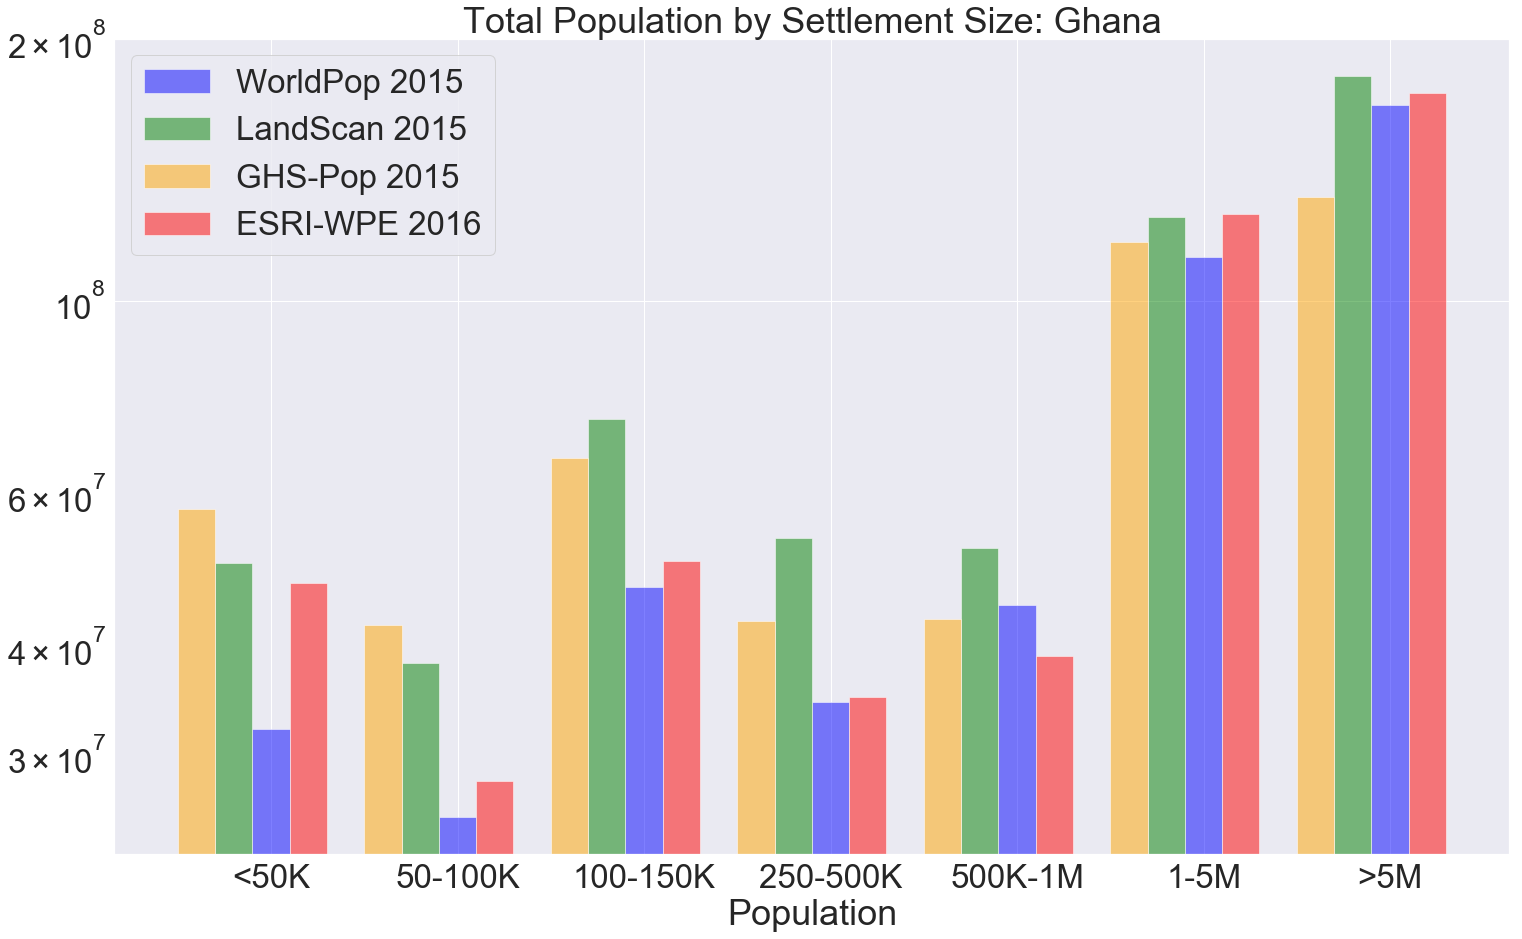

In [34]:
# import plotly.plotly as py
# import plotly.tools as tls

import matplotlib.pyplot as plt

dictionary = plt.figure()

WP2015_bar = {'<50K':WP2015_50k, '50-100K': WP2015_100k, '100-150K':WP2015_250k,
    '250-500K' : WP2015_500k, '500K-1M' : WP2015_1m, '1-5M' : WP2015_5m, '>5M' : WP2015_5mplus
             }

# WP2000_bar = {u'Label0':WP2000_50k, u'Label1': WP2000_100k, u'Label2':WP2000_250k,
#     u'Label3' : WP2000_500k, u'Label4' : WP2000_1m, u'Label5' : WP2000_5m, u'Label6' : WP2000_5mplus
#     }

LS2015_bar = {u'Label0':LS2015_50k, u'Label1': LS2015_100k, u'Label2':LS2015_250k,
    u'Label3' : LS2015_500k, u'Label4' : LS2015_1m, u'Label5' : LS2015_5m, u'Label6' : LS2015_5mplus
    }

GHS2015_bar = {u'Label0':GHS2015_50k, u'Label1': GHS2015_100k, u'Label2':GHS2015_250k,
    u'Label3' : GHS2015_500k, u'Label4' : GHS2015_1m, u'Label5' : GHS2015_5m, u'Label6' : GHS2015_5mplus
    }

WPE2016_bar = {u'Label0':WPE2016_50k, u'Label1': WPE2016_100k, u'Label2':WPE2016_250k,
    u'Label3' : WPE2016_500k, u'Label4' : WPE2016_1m, u'Label5' : WPE2016_5m, u'Label6' : WPE2016_5mplus
   }

# make plot
sns.set(font_scale=3)
x = [0,1,2,3,4,5,6]
y = [0-.2,1-.2,2-.2,3-.2,4-.2,5-.2,6-.2]
z = [0-.4,1-.4,2-.4,3-.4,4-.4,5-.4,6-.4]
a = [0+.2,1+.2,2+.2,3+.2,4+.2,5+.2,6+.2]



plt.bar(x, WP2015_bar.values(), width=0.2, align='center', alpha  = 0.5, color = 'Blue')

plt.bar(y, LS2015_bar.values(), width=0.2, align='center', alpha  = 0.5, color = 'Green')
plt.bar(z, GHS2015_bar.values(), width=0.2, align='center', alpha  = 0.5, color = 'Orange')
plt.bar(a, WPE2016_bar.values(), width=0.2, align='center', alpha = 0.5, color = 'Red')

bar_leg = ['WorldPop 2015', 'LandScan 2015', 'GHS-Pop 2015', 'ESRI-WPE 2016']
plt.legend(bar_leg,loc=2)



#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(WP2015_bar)), WP2015_bar.keys())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25, 15)
plt.gca().set_yscale('log')
plt.xlabel('Population')
plt.ylabel('')
plt.title('Total Population by Settlement Size: Ghana')
# fig.savefig('/Users/cascade/Desktop/'+'PopGhana_bar.png', dpi=700, transparent=True)


# ax.bar(x-0.2, y,width=0.2,color='b',align='center')
# ax.bar(x, z,width=0.2,color='g',align='center')
# ax.bar(x+0.2, k,width=0.2,color='r',align='center')

In [ ]:
# import plotly.plotly as py
# import plotly.tools as tls

import matplotlib.pyplot as plt

dictionary = plt.figure()

bar_leg = ['WorldPop 2015', 'WorldPop 2000']


WP2015_Nigeria_bar = {'<50K':WP2015_Nigeria_50k, '50-100K': WP2015_Nigeria_100k, '100-150K':WP2015_Nigeria_250k,
    '250-500K' : WP2015_Nigeria_500k, '500K-1m' : WP2015_Nigeria_1m, '1-5M' : WP2015_Nigeria_5m, '>5M' : WP2015_Nigeria_5mplus
             }

WP2000_Nigeria_bar = {u'Label0':WP2000_Nigeria_50k, u'Label1': WP2000_Nigeria_100k, u'Label2':WP2000_Nigeria_250k,
    u'Label3' : WP2000_Nigeria_500k, u'Label4' : WP2000_Nigeria_1m, u'Label5' : WP2000_Nigeria_5m, u'Label6' : WP2000_Nigeria_5mplus
    }

# make plot
sns.set(font_scale=2.2)

plt.bar(range(len(WP2000_Nigeria_bar)), WP2000_Nigeria_bar.values(), align='center', alpha  = 0.5, color = 'Purple')
plt.bar(range(len(WP2015_Nigeria_bar)), WP2015_Nigeria_bar.values(), align='center', alpha = 0.5, color = 'Orange')
plt.legend(bar_leg,loc=2)



#plt.bar(range(len(D)), D.values(), align='center')

plt.xticks(range(len(WP2015_Nigeria_bar)), WP2015_Nigeria_bar.keys())

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.gca().set_yscale('log')
#fig.savefig('/Users/cascade/Desktop/'+'WP152000_Nigeria_bar.png', dpi=700)

In [ ]:
# WP 2000 & 2000 Bar Plots Chunk by City Size

# drop FID
print(len(WP2015))
WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
print(len(WP2015))

# drop <5000
WP2015 = WP2015[WP2015['PopTot'] > 5000]
print(len(WP2015))

In [ ]:
WP2015_aez = WP2015[WP2015['aez_class'] != '0']
WP2015_aez = WP2015_aez[WP2015_aez['aez_class'] != 'NoClass']

# ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2000_aez)
# ax.set(xscale="log")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.55)
# plt.xlabel('Population')
# plt.ylabel('')
# plt.title('WP2000 Distribution by AEZ')

# # fig.savefig('test2png.png', dpi=100)

In [ ]:
WP_med2015 = round(WP2015_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
#  66313.0 - 2000
WP_med2015

In [ ]:
WP_med2000

In [ ]:
WP2000_aez = WP2000[WP2000['aez_class'] != '0']
WP2000_aez = WP2000_aez[WP2000_aez['aez_class'] != 'NoClass']
WP2015_aez = WP2015[WP2015['aez_class'] != '0']
WP2015_aez = WP2015_aez[WP2015_aez['aez_class'] != 'NoClass']

# ax = sns.boxplot(x = 'PopTot', y = 'aez_class', data = WP2000_aez)
# ax.set(xscale="log")

# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(18.5, 10.55)
# plt.xlabel('Population')
# plt.ylabel('')
# plt.title('WP2000 Distribution by AEZ')

#fig.savefig('/Users/cascade/Desktop/'+'WP2000_aez.png', dpi=700)


In [ ]:
round(WP2000_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
round(WP2015_aez.groupby('aez_class')['PopTot'].median())

In [ ]:
100*((496037 - 361052)/361052)

In [ ]:
# add col for concat, drop FID duplicates

datasets_string = ['GHS2000', 'GHS2015', 'WP2000', 'WP2015', 'LS2015', 'WPE2016']

# for i, dataset in enumerate(datasets_in):
    
#     dataset['dataset'] = datasets_string[i]
#     dataset = dup_drop(dataset, 'FID', 'first')

WPE2016['dataset'] = 'WPE2016'
WPE2016 = dup_drop(WPE2016, 'FID', 'first')

In [ ]:
# drop cities with less than 5000 
GHS2015 = GHS2015[GHS2015['PopTot']>=5000] 
WP2015 = WP2015[WP2015['PopTot']>=5000] 
LS2015 = LS2015[LS2015['PopTot']>=5000] 
WPE2016 = WPE2016[WPE2016['PopTot']>=5000] 


datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


datasets15_concat = pd.concat(datasets2015, ignore_index=True)

# datasets_concat = pd.concat(datasets_in, ignore_index=True)

In [ ]:
datasets15_concat.shape

In [ ]:
min(WPE2016['PopTot'])

In [ ]:
sns.set(font_scale=3)
ax = sns.boxplot(x = 'PopTot', y = 'dataset', data = datasets15_concat)
ax.set(xscale="log") 
plt.xlabel('Population')
plt.ylabel('')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

#fig.savefig('/Users/cascade/Desktop/'+'data15-hist.png', dpi=700)

In [ ]:
datasets2015 = [GHS2015, WP2015, LS2015, WPE2016]


GHS2015_sort = GHS2015['PopTot'].sort_values()
X0, y0 = p_X_gt_x(GHS2015_sort)

WP2015_sort = WP2015['PopTot'].sort_values()
X1, y1 = p_X_gt_x(WP2015_sort)

LS2015_sort = LS2015['PopTot'].sort_values()
X2, y2 = p_X_gt_x(LS2015_sort )

WPE2016_sort = WPE2016['PopTot'].sort_values()
X3, y3 = p_X_gt_x(WPE2016_sort)


In [ ]:
fig = plt.figure()
ax = plt.subplot()
ax.plot(X0, y0, label ='GHS2015')
ax.plot(X1, y1, label ='WP2015')
ax.plot(X2, y2, label ='LS2015')
ax.plot(X3, y3, label ='WPE2016')
plt.xscale('log')
plt.title('Inverse cumulative distribution of city sizes by dataset')
plt.xlabel('x(Population)')
plt.ylabel('P[X>=x]')
ax.legend()
fig.set_size_inches(18.5, 10.5)


In [ ]:
#GHS2000.loc[(GHS2000['PopTot'] > 5000) & (GHS2000['PopTot'] < 10000), 'PopTot'].sum()
test = GHS2015[GHS2015['PopTot'] <5000000]

a =test.loc[(test['PopTot'] > 1000000), 'PopTot'].sum()
                                         
                                          
#GHS2000.loc[GHS2000['PopTot'] <50000 & GHS2000['PopTot'] >5000, 'PopTot'].sum()

In [ ]:
import numpy as np
import matplotlib.pyplot as pp
val = 0. # this is the value where you want the data to appear on the y-axis.
 # just as an example array
pp.plot(a, 'x')
pp.show()

In [ ]:
WPE2016.head()

a = GHS2015[GHS2015['PopTot']>0]
a = GHS2015[GHS2015['PopTot']<1000000]
b = GHS2000[GHS2000['PopTot']>0]
b = GHS2000[GHS2000['PopTot']<1000000]


plt.hist(np.log10(b['PopTot']), alpha=0.5, label='WP2000')
plt.hist(np.log10(a['PopTot']), alpha=0.5, label='WP2015')
#plt.hist(np.log10(LS2015['PopTot']), alpha=0.5, label='x')
#plt.hist(np.log10(a['PopTot']), alpha=0.5, label='x')



plt.legend(loc='upper right')
# plt.show()


## Pairwise Grouping

In [ ]:
Drop Doubles based on OSM Lat/Lon

GHS2000_drop = dup_drop(GHS2000, 'osm_id', 'first')
WP2000_drop = dup_drop(WP2000, 'osm_id', 'first')

GHS2015_drop = dup_drop(GHS2015, 'osm_id', 'first')
WP2015_drop = dup_drop(WP2015 , 'osm_id', 'first')
LS2015_drop = dup_drop(LS2015 , 'osm_id', 'first')
WPE2016_drop = dup_drop(WPE2016 , 'osm_id', 'first')

In [ ]:
GHS2015_pop = GHS2015_drop[['str_id','PopTot']]
WP2015_pop = WP2015_drop[['str_id','PopTot']]
LS2015_pop = LS2015_drop[['str_id','PopTot']]
WPE2016_pop = WPE2016_drop[['str_id','PopTot']]

data_frames = [GHS2015_pop, WP2015_pop, LS2015_pop, WPE2016_pop]

df2015_merged = reduce(lambda  left,right: pd.merge(left,right,on=['str_id'], how='inner'), data_frames)

print(len(df2015_merged))
df2015_merged.head(4)


In [ ]:
df2015_merged.columns = ['str_id', 'GHS15_Pop', 'WP15_Pop', 'LS15_Pop', 'WPE2016_pop' ]
df2015_merged.head()

In [ ]:
df_2015_GHS_WP = df2015_merged[['WPE2016_pop','LS15_Pop']]
print(df_2015_GHS_WP.shape)


df_2015_GHS_WP = df_2015_GHS_WP.drop_duplicates(keep='first')
print(df_2015_GHS_WP.shape)


In [ ]:
stats.pearsonr(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'])

In [ ]:
df_2015_GHS_WP.dtypes

In [ ]:
# Pairwise scatter plots

fig = plt.figure()
ax = plt.gca()
ax.scatter(df_2015_GHS_WP['WPE2016_pop'], df_2015_GHS_WP['LS15_Pop'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('ESRI - WPE 2016')
plt.ylabel('LandScan 2015')

#fig.savefig('/Users/cascade/Desktop/'+'WPE16-LS15.png', dpi=700)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

import seaborn as sns
corr = df2015_merged.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
import matplotlib.pyplot as plt

#matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

In [ ]:
from scipy import stats
xA = df_merge['PopTot_x']
yA = df_merge['PopTot_y']

result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
from scipy import stats
xR = test_df_drop['x']
yR = test_df_drop['y']

result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
test_df_min = test_df_drop[test_df_drop['x']<=1000000]
print(len(test_df_min))
test_df_min = test_df_drop[test_df_drop['y']<=1000000]
print(len(test_df_min))

In [ ]:
test_df_min[test_df_min['y']>=1000000]

In [ ]:
xW = test_df_min['x']
yW = test_df_min['y']

result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
result

In [ ]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('WPE 2016')
plt.ylabel('World Pop 2015')

# Old Code

In [ ]:
# df_test_a = WP2015[['osm_id', 'PopTot']]


# df_test_b = GHS2015[['osm_id', 'PopTot']]
# print(df_test_b.shape)
# print(df_test_a.shape)

# df_test_a_drop = df_test_a.drop_duplicates('osm_id', keep=False)
# df_test_b_drop = df_test_b.drop_duplicates('osm_id', keep=False)
# print(df_test_b_drop.shape)
# print(df_test_a_drop.shape)

In [ ]:
# find duplicates

# dupsA = pd.concat(g for _, g in test_df.groupby("str_id") if len(g) > 1)
# dupsA

In [ ]:
# x = df_merge['PopTot_x']
# y = df_merge['PopTot_y']
# str_id_merge = df_merge['str_id']
# test_df = pd.DataFrame()
# test_df['x'] = x
# test_df['y'] = y
# test_df['str_id_merge'] = str_id_merge



# test_df['x_string'] = test_df.x.astype(str)
# test_df['y_string'] = test_df.y.astype(str)
# test_df['str_id'] = test_df.x_string.astype(str)+test_df.y_string.astype(str)

In [ ]:
#axl = pd.scatter_matrix(df2015_merged, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

# import seaborn as sns
# corr = df2015_merged.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

In [ ]:
# import matplotlib.pyplot as plt

# #matplotlib.pyplot.scatter(df_merge['PopTot_x'], df_merge['PopTot_y'])

# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['PopTot_x'], test_df_drop['PopTot_y'] , c='blue', alpha=0.05, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_drop['x'], test_df_drop['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# from scipy import stats
# xA = df_merge['PopTot_x']
# yA = df_merge['PopTot_y']

# result = stats.pearsonr(xA, yA) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# from scipy import stats
# xR = test_df_drop['x']
# yR = test_df_drop['y']

# result = stats.pearsonr(xR, yR) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# test_df_min = test_df_drop[test_df_drop['x']<=1000000]
# print(len(test_df_min))
# test_df_min = test_df_drop[test_df_drop['y']<=1000000]
# print(len(test_df_min))

In [ ]:
# test_df_min[test_df_min['y']>=1000000]

In [ ]:
# xW = test_df_min['x']
# yW = test_df_min['y']

# result = stats.pearsonr(xW, yW) # return is (Pearson’s correlation coefficient, 2-tailed p-value)
# result

In [ ]:
# fig = plt.figure()
# ax = plt.gca()
# ax.scatter(test_df_min['x'], test_df_min['y'], c='blue', alpha=0.1, edgecolors='none')
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.xlabel('WPE 2016')
# plt.ylabel('World Pop 2015')

In [ ]:
# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WP2015))
# WP2015 = WP2015.drop_duplicates('FID', keep = 'first')
# print(len(WP2015))

# # drop <5000
# WP2015 = WP2015[WP2015['PopTot'] > 5000]
# print(len(WP2015))

# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WP2015))
# LS2015 = LS2015.drop_duplicates('FID', keep = 'first')
# print(len(LS2015))

# # drop <5000
# GHS2015 = GHS2015[GHS2015['PopTot'] > 5000]
# print(len(GHS2015))

# # WP 2000 & 2015 Bar Plots Chunk by City Size

# # drop FID
# print(len(WPE2016))
# WPE2016 = WPE2016.drop_duplicates('FID', keep = 'first')
# print(len(WPE2016))

# # drop <5000
# WPE2016 = WPE2016[WPE2016['PopTot'] > 5000]
# print(len(WPE2016))


In [ ]:
# # Loop through datasets to drop FID duplicates and remove cities with population less than 5000

# for dataset in datasets_in:
    
#     # drop FID
#     print(len(dataset))
#     dataset = dataset.drop_duplicates('FID', keep = 'first')
#     print(len(dataset))
    
#     # drop <5000
#     dataset = dataset[dataset['PopTot'] > 5000]

#     print(len(dataset))